In [83]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt


In [84]:
# Data Loading
noise = 'noise1'
modelname = "inception" # resnet or inception

train_data_dir = f'/home/vincent/repos/concept_discovery/data/fc_dataset/{noise}/train'
test_data_dir = f'/home/vincent/repos/concept_discovery/data/fc_dataset/{noise}/val'
test_nostamp_data_dir = '/home/vincent/repos/concept_discovery/data/fc_dataset/nostamp/val'

if modelname == "resnet":
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224,scale=(0.5,1.0)), # I limit the crop before resize to ensure the stamp is present. I also reduced the max_shift of the stamp from the center for the same reason.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
elif modelname == "inception":
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(299),  # InceptionV3 requires input size of 299x299
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

else:
    raise ValueError("Invalid modelname. Supported values are 'resnet' and 'inception'.")


train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=train_transform)

# Calculate the sizes of the training and validation sets
torch.manual_seed(0)
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training, adjust as needed
val_size = total_size - train_size
# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_nostamp = torchvision.datasets.ImageFolder(test_nostamp_data_dir, transform=test_transform)
test_loader_nostamp = torch.utils.data.DataLoader(test_dataset_nostamp, batch_size=32, shuffle=False)

# Model Definition (ResNet-50)
if modelname == "resnet":
    model = models.resnet50(pretrained=False)
elif modelname == "inception":
    # model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=False)
    model = models.inception_v3(pretrained=False, aux_logits=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Modify the output layer for binary classification

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


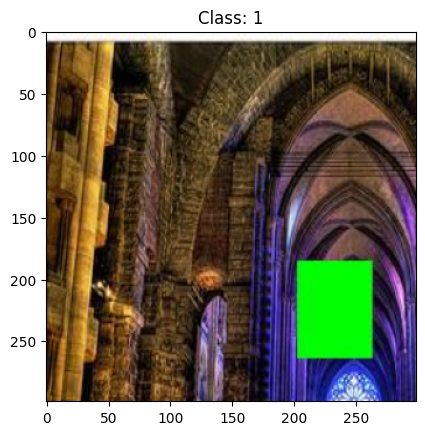

In [85]:
# Plot one random image from the dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Convert the tensor image to a NumPy array and denormalize it
image = images[0].numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# Denormalize the image
image = image.transpose((1, 2, 0))  # Transpose image dimensions from (3, 224, 224) to (224, 224, 3)
image = std * image + mean
image = np.clip(image, 0, 1)  # Clip values to [0, 1] in case of rounding errors

# Plot the image
plt.imshow(image)
plt.title(f'Class: {labels[0].item()}')
plt.show()

In [86]:
num_epochs = 100
# Define variables to track early stopping
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve
early_stopping_counter = 0

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Print progress and check for early stopping
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= patience:
        print(f'Early stopping after {patience} epochs without improvement in validation loss.')
        break

print('Finished Training')


Epoch [1/100], Training Loss: 0.6620, Validation Loss: 0.8680
Epoch [2/100], Training Loss: 0.6703, Validation Loss: 0.6362
Epoch [3/100], Training Loss: 0.6324, Validation Loss: 0.6102
Epoch [4/100], Training Loss: 0.5944, Validation Loss: 0.5412
Epoch [5/100], Training Loss: 0.5275, Validation Loss: 0.4959


In [ ]:
# Save weights
torch.save(model.state_dict(), f'/home/vincent/repos/concept_discovery/weights/{modelname}_model_weights_{noise}.pth')

In [ ]:
# load weights:
# model.load_state_dict(torch.load(f'/home/vincent/repos/concept_discovery/weights/resnet_model_weights_{noise}.pth'))

# Evaluation (on test set)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader_nostamp:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy no stamp: {accuracy:.2f}%')

Test Accuracy: 93.96%
Test Accuracy no stamp: 66.08%


In [ ]:
# 100 epochs Inception
# Test acc model_noise0 on test_stamp_noise0: 
# Test acc model_noise0 on test_nostamp: 

# Test acc model_noise0.05 on test_stamp_noise0.05: 
# Test acc model_noise0.05 on test_nostamp: 

# Test acc model_noise0.1 on test_stamp_noise0.1: 
# Test acc model_noise0.1 on test_nostamp: 

# Test acc model_noise0.2 on test_stamp_noise0.2: 
# Test acc model_noise0.2 on test_nostamp: 

# Test acc model_noise0.5 on test_stamp_noise0.5: 
# Test acc model_noise0.5 on test_nostamp: 

# Test acc model_noise0.8 on test_stamp_noise0.8: 
# Test acc model_noise0.8 on test_nostamp: 

# Test acc model_noise0.9 on test_stamp_noise0.9: 
# Test acc model_noise0.9 on test_nostamp: 

# Test acc model_noise1 on test_stamp_noise1: 
# Test acc model_noise1 on test_nostamp: 

In [ ]:
# 100 epochs Resnet
# Test acc model_noise0 on test_stamp_noise0: 99.95%
# Test acc model_noise0 on test_nostamp: 51.26%

# Test acc model_noise0.05 on test_stamp_noise0.05: 97.48%
# Test acc model_noise0.05 on test_nostamp: 51.51%

# Test acc model_noise0.1 on test_stamp_noise0.1: 94.75%
# Test acc model_noise0.1 on test_nostamp: 59.80%

# Test acc model_noise0.2 on test_stamp_noise0.2: 92.49%
# Test acc model_noise0.2 on test_nostamp: 84.05%

# Test acc model_noise0.5 on test_stamp_noise0.5: 96.85%
# Test acc model_noise0.5 on test_nostamp: 93.72%

# Test acc model_noise0.8 on test_stamp_noise0.8: 81.09%
# Test acc model_noise0.8 on test_nostamp: 84.17%

# Test acc model_noise0.9 on test_stamp_noise0.9: 95.27%
# Test acc model_noise0.9 on test_nostamp: 93.34%

# Test acc model_noise1 on test_stamp_noise1: 94.01%
# Test acc model_noise1 on test_nostamp: 91.58%